In [1]:
import numpy as np, json, matplotlib,  pandas as pd, seaborn as sn
from datetime import datetime
from conceptual_engineering_assistant import Concept, ConceptualEngineeringAssistant
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain.document_loaders import WikipediaLoader

In [2]:
SAMPLE_SIZE = 20
females = np.random.choice(json.load(open('data/females-2023-03-15.json', 'r')), SAMPLE_SIZE)
males = np.random.choice(json.load(open('data/males-2023-03-15.json', 'r')), SAMPLE_SIZE)
non_binaries = np.random.choice(json.load(open('data/non-binaries-2023-03-15.json', 'r')), SAMPLE_SIZE)
trans_men = np.random.choice(json.load(open('data/trans-men-2023-03-15.json', 'r')), SAMPLE_SIZE)
trans_women = np.random.choice(json.load(open('data/trans-women-2023-03-15.json', 'r')), SAMPLE_SIZE)
sample = np.concatenate((females, trans_women, non_binaries, trans_men, males))

In [3]:
for entity in sample:
    entity["description"] = WikipediaLoader(query=entity["name"], load_max_docs=1).load()[0].page_content[:400]

In [4]:
entities = pd.DataFrame.from_records(sample)
entities

,item,name,article,gender,description
0,http://www.wikidata.org/entity/Q67488,Christina Schwanitz,https://en.wikipedia.org/wiki/Christina_Schwanitz,female,Christina Schwanitz (German pronunciation: [kʁ...
1,http://www.wikidata.org/entity/Q17135,Soong Mei-ling,https://en.wikipedia.org/wiki/Soong_Mei-ling,female,"Soong Mei-ling (also spelled Soong May-ling, ..."
2,http://www.wikidata.org/entity/Q4826,Rosa Valetti,https://en.wikipedia.org/wiki/Rosa_Valetti,female,Rosa Valetti (born Rosa Alice Vallentin; 25 Ja...
3,http://www.wikidata.org/entity/Q68761,Elsa Einstein,https://en.wikipedia.org/wiki/Elsa_Einstein,female,Elsa Einstein (18 January 1876 – 20 December 1...
4,http://www.wikidata.org/entity/Q10479,"Catherine, Princess of Wales","https://en.wikipedia.org/wiki/Catherine,_Princ...",female,"Catherine, Princess of Wales (born Catherine ..."
...,...,...,...,...,...
95,http://www.wikidata.org/entity/Q157,François Hollande,https://en.wikipedia.org/wiki/Fran%C3%A7ois_Ho...,male,François Gérard Georges Nicolas Hollande (Fren...
96,http://www.wikidata.org/entity/Q3234,Jochen Rindt,https://en.wikipedia.org/wiki/Jochen_Rindt,male,Karl Jochen Rindt (German: [ˈjɔxn̩ ˈʁɪnt]; 18 ...
97,http://www.wikidata.org/entity/Q11893,Maximilian Hell,https://en.wikipedia.org/wiki/Maximilian_Hell,male,Maximilian Hell (Hungarian: Hell Miksa) (born ...
98,http://www.wikidata.org/entity/Q29773,Flash (gamer),https://en.wikipedia.org/wiki/Flash_(gamer),male,"Lee Young-ho (Korean: 이영호, born July 5, 1992),..."


In [5]:
haslanger_woman_definition = """(i) S is regularly and for the most part observed or imagined to have 
certain bodily features presumed to be evidence of a female’s biological role in reproduction; 
(ii) that S has these features marks S within the dominant ideology of S’s society as someone who 
ought to occupy certain kinds of social position that are in fact subordinate (and so motivates 
and justifies S’s occupying such a position); and (iii) the fact that S satisfies (I) and (ii) plays 
a role in S’s systematic subordination, that is, along some dimension, S’s social position is oppressive, 
and S’s satisfying (i) and (ii) plays a role in that dimension of subordination"""

In [ ]:
oed_woman_definition = "S is an adult female human being. The counterpart of man (see man n.1 II.4.)."

In [7]:
haslanger_woman = Concept("woman", "S", haslanger_woman_definition)

In [8]:
oed_woman = Concept("woman", "S", oed_woman_definition)

In [9]:
cea = ConceptualEngineeringAssistant()

In [10]:
haslanger_classifications = pd.DataFrame( 
    [ cea.classify_entity_with_description(haslanger_woman, entity["name"], entity["description"]) for entity in sample ], 
    columns = [ 'entity' , 'in_extension', 'rationale' ] 
    )

In [11]:
haslanger_results = pd.concat([entities[["name", "gender"]], haslanger_classifications[["in_extension", "rationale"]]], axis=1)
results_styler = haslanger_results.style.set_properties(**{"text-align": "left", "overflow-wrap": "break-word"})
results_styler.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) 

,name,gender,in_extension,rationale
0,Christina Schwanitz,female,True,"Christina Schwanitz is identified as a woman, which implies that she is observed to have certain bodily features associated with the female biological role in reproduction. As a woman in society, she may be expected to occupy certain social positions, potentially subordinate ones. Furthermore, her identity as a woman may play a role in any systematic subordination she experiences. Therefore, according to the provided definition, Christina Schwanitz is a woman."
1,Soong Mei-ling,female,True,"Soong Mei-ling satisfies all the conditions of the definition provided for a woman. She was observed to have the bodily features associated with a female's biological role in reproduction (i). She was marked within her society's dominant ideology as someone who should occupy certain social positions, in this case, the First Lady of the Republic of China, a position that is typically occupied by women (ii). And her social position, while prominent and influential, was still within a societal structure that systematically subordinates women, thus satisfying condition (iii). Therefore, according to the provided definition, Soong Mei-ling is a woman."
2,Rosa Valetti,female,True,"Rosa Valetti is identified as a woman based on the given definition. She is observed to have the bodily features associated with a female's biological role in reproduction (i). As an actress, cabaret performer, and singer in a society that often subordinates these roles, she occupies a social position that is considered subordinate within the dominant ideology of her society (ii). Her roles in society and her biological features contribute to her systematic subordination, making her social position oppressive along some dimension (iii). Therefore, Rosa Valetti fits the definition of a woman."
3,Elsa Einstein,female,True,"Elsa Einstein satisfies all the conditions of the given definition of a woman. She was observed to have the bodily features associated with the female biological role in reproduction (i), she occupied social positions that were considered appropriate for women in her society (ii), and her social position was subordinate in some ways due to her gender (iii). Therefore, according to this definition, Elsa Einstein is a woman."
4,"Catherine, Princess of Wales",female,True,"Catherine, Princess of Wales, satisfies all the conditions in the definition of a woman. She is observed to have the bodily features associated with the female biological role in reproduction (i). As a member of the British royal family, she occupies a certain social position that is marked within the dominant ideology of her society (ii). Although her social position as a royal is not subordinate, it can be argued that as a woman in a patriarchal society, there are dimensions in which her social position could be considered oppressive (iii). Therefore, according to the given definition, Catherine, Princess of Wales is a woman."
5,Janica Kostelić,female,True,"Janica Kostelić is identified as a woman, which implies that she is observed to have certain bodily features associated with the female biological role in reproduction. Furthermore, her societal role as a woman in Croatia, where she was born and raised, likely influenced her social position, even though her achievements as an alpine ski racer have elevated her status. Therefore, she satisfies both conditions (i) and (ii) of the definition. The third condition (iii) is more complex and would require more specific information about her personal experiences, but it does not negate her identification as a woman."
6,Sonja Bernhardt,female,True,"Sonja Bernhardt satisfies the conditions of the definition provided for a woman. She is presumably observed to have the bodily features associated with a female's biological role in reproduction (i). She occupies a social position that, while not necessarily subordinate, is within a field (information technology) that is often m

In [12]:
oed_classifications = pd.DataFrame( 
    [ cea.classify_entity_with_description(oed_woman, entity["name"], entity["description"]) for entity in sample ], 
    columns = [ 'entity' , 'in_extension', 'rationale' ] 
    )

In [13]:
oed_results = pd.concat([entities[["name", "gender"]], oed_classifications[["in_extension", "rationale"]]], axis=1)
results_styler = oed_results.style.set_properties(**{"text-align": "left", "overflow-wrap": "break-word"})
results_styler.set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) 

,name,gender,in_extension,rationale
0,Christina Schwanitz,female,True,"The text states that Christina Schwanitz is a retired German shot putter, indicating that she is a human being. It also refers to her using female pronouns, indicating that she is female. Since she was born in 1985, she is an adult. Therefore, according to the provided definition, Christina Schwanitz is a woman."
1,Soong Mei-ling,female,True,"Soong Mei-ling was an adult female human being, which fits the definition of a woman. Additionally, she was referred to as ""Madame,"" a title typically used for women. Therefore, it is true that Soong Mei-ling was a woman."
2,Rosa Valetti,female,True,"Rosa Valetti is identified as a female in the text. She is also referred to as an actress, which implies that she is an adult. Therefore, according to the definition provided, Rosa Valetti is a woman."
3,Elsa Einstein,female,True,"The text states that Elsa Einstein was an adult female human being, which fits the definition of a woman. Therefore, it is true that Elsa Einstein is a woman."
4,"Catherine, Princess of Wales",female,True,"Catherine, Princess of Wales, is described as an adult female human being, which aligns with the definition of a woman. Therefore, it is true that she is a woman."
5,Janica Kostelić,female,True,"Janica Kostelić is described as an adult female human being, which aligns with the given definition of a woman. Therefore, it is true that Janica Kostelić is a woman."
6,Sonja Bernhardt,female,True,"The text identifies Sonja Bernhardt as a female. Since she is an adult and a human being, she fits the definition of a woman."
7,Hertha Sponer,female,True,"The text states that Hertha Sponer was a female human being who was an adult, as she was a physicist, chemist, and faculty member at Duke University. Therefore, according to the provided definition, she is a woman."
8,Gail Williams,female,True,"The text provides information that Gail Ann Williams is an adult human being who is female. According to the provided definition, an adult female human being is a woman. Therefore, Gail Williams is a woman."
9,Angela Winkler,female,True,"Angela Winkler is identified as a female and is an adult, as indicated by her birth date in 1944. Therefore, she fits the definition of a woman."


In [14]:
def confusion_matrix(results):
    return results[["gender", "in_extension"]].groupby(['gender','in_extension'], sort=False).size().unstack(fill_value=0)[["True", "Unknown", "False"]]

<Axes: xlabel='in_extension', ylabel='gender'>

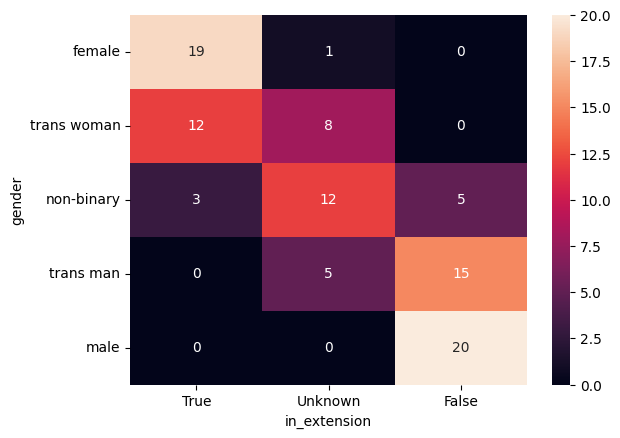

In [15]:
sn.heatmap(confusion_matrix(haslanger_results), annot=True)

<Axes: xlabel='in_extension', ylabel='gender'>

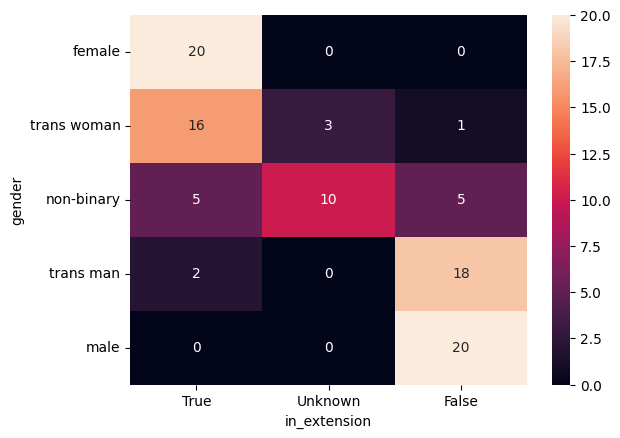

In [16]:
sn.heatmap(confusion_matrix(oed_results), annot=True)

In [17]:
def evaluation_record(model, concept, data):
    return {
        "created": datetime.now().isoformat(),
        "model": {
            "name": cea.model_name,
            "temperature": cea.temperature,
        },
        "concept": {
            "term": concept.term,
            "variable": concept.variable,
            "definition": concept.definition,
        },
        "data": data.to_dict('records'),
    }

In [21]:
haslanger_evaluation_record = evaluation_record(cea, haslanger_woman, pd.concat([entities, haslanger_classifications], axis=1))
oed_evaluation_record = evaluation_record(cea, oed_woman, pd.concat([entities, oed_classifications], axis=1))
json.dump(
    haslanger_evaluation_record, 
    open(f'data/{haslanger_evaluation_record["model"]["name"]}_{haslanger_evaluation_record["concept"]["term"]}_{haslanger_evaluation_record["created"]}.json', 'w')
)
json.dump(
    oed_evaluation_record, 
    open(f'data/{oed_evaluation_record["model"]["name"]}_{oed_evaluation_record["concept"]["term"]}_{oed_evaluation_record["created"]}.json', 'w')
)